filtered data: https://jmcauley.ucsd.edu/data/googlelocal/kcore/

In [102]:
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

In [2]:
def parseData(fname):
    for l in gzip.open(fname):
        d = eval(l)
        yield d

In [4]:
#filtering out users with <5 interactions
data_CA5 = list(parseData("../CA_5.json.gz"))

In [15]:
data_CA5[0]

{'rating': 4.0,
 'reviewerName': 'Mary Gainza',
 'reviewText': 'Gap always has a jean that fits awesomely, i wish their prices were a bit competitive in comparison to their outlets, also the amount of the pieces they have in store sometimes fly so quick that is hard to find an specific size with their best sellers, but in general i really like this store and most of their products.',
 'categories': ['Clothing Store',
  "Women's Clothing Store",
  "Children's Clothing Store"],
 'gPlusPlaceId': '100556368174926958612',
 'unixReviewTime': 1355436757,
 'reviewTime': 'Dec 13, 2012',
 'gPlusUserId': '100000715097692381911'}

In [9]:
# filtering out users with <10 interactions, subset of CA_5
# only users with 10 or more interactions
data_CA10 = list(parseData('CA_10.json.gz'))

In [16]:
data_CA10[0]

{'rating': 4.0,
 'reviewerName': 'Rick Casady',
 'reviewText': None,
 'categories': ['Sushi Restaurant', 'Asian Restaurant', 'Japanese Restaurant'],
 'gPlusPlaceId': '100539657974695665920',
 'unixReviewTime': 1302881457,
 'reviewTime': 'Apr 15, 2011',
 'gPlusUserId': '100003840837471130074'}

In [5]:
places_CA = list(parseData('../places_CA.json.gz'))

In [ ]:
print(len(data_CA5),len(data_CA10),len(places_CA),len(reviews_CA))

In [28]:
places_CA[0]

{'name': 'Diamond Valley Lake Marina',
 'price': None,
 'address': ['2615 Angler Ave', 'Hemet, CA 92545'],
 'hours': [['Monday', [['6:30 am--4:15 pm']]],
  ['Tuesday', [['6:30 am--4:15 pm']]],
  ['Wednesday', [['6:30 am--4:15 pm']], 1],
  ['Thursday', [['6:30 am--4:15 pm']]],
  ['Friday', [['6:30 am--4:15 pm']]],
  ['Saturday', [['6:30 am--4:15 pm']]],
  ['Sunday', [['6:30 am--4:15 pm']]]],
 'phone': '(951) 926-7201',
 'closed': False,
 'gPlusPlaceId': '104699454385822125632',
 'gps': [33.703804, -117.003209]}

# Prep

In [116]:
#y
ratings = [d["rating"] for d in data_CA5]

In [117]:
len(ratings)

163408

# Baseline 1: Average Rating

In [12]:
#Calculate Global Average
ratingGlobalAvg = np.mean(ratings)
ratingGlobalAvg

4.049765005385293

<Figure size 432x288 with 0 Axes>

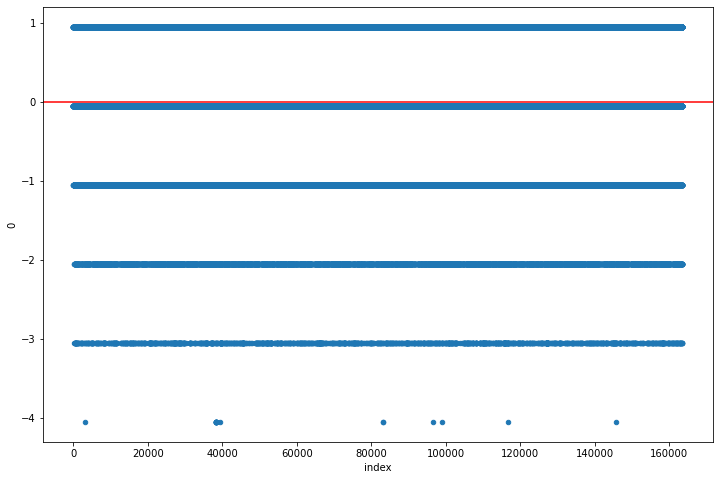

In [70]:
#Comparing estimate(baseline) to true values
plt.figure()
ax = pd.DataFrame(ratings-ratingGlobalAvg).reset_index().plot(kind="scatter", x="index", y=0, figsize=(12, 8))
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [75]:
print("MAE: ", str(np.mean(((ratings-ratingGlobalAvg)**2))))
print("MSE: ", str(np.mean(abs((ratings-ratingGlobalAvg)))))

MAE:  0.7764449168719206
MSE:  0.6535482386098458


# Baseline 2: Weighted Average from Categories

In [41]:
#Calculate Category Averages
cats = defaultdict(list)
for d in data_CA5:
    if d['categories']:
        for c in d['categories']:
            cats[c].append(d['rating'])
    else:
        cats["None"].append(d['rating'])
ratingsCatAvg = {c: np.mean(cats[c]) for c in cats}

In [42]:
#Plan: Convert each list of cats to list of avgs, get avg of that
#Plan2: Weight avg's before combining

In [78]:
estimatesCatAvg = [
    np.mean([ratingsCatAvg[c] for c in d["categories"]]) 
    if d["categories"] else ratingGlobalAvg
    for d in data_CA5
]

In [79]:
#Calculating error
errors = (pd.Series(estimatesCatAvg) - pd.Series(ratings))
errors

0         0.094699
1         0.080110
2        -0.031811
3        -1.103261
4        -0.944600
            ...   
163403   -0.028142
163404   -0.929040
163405    0.092204
163406   -0.197509
163407    2.027361
Length: 163408, dtype: float64

<Figure size 432x288 with 0 Axes>

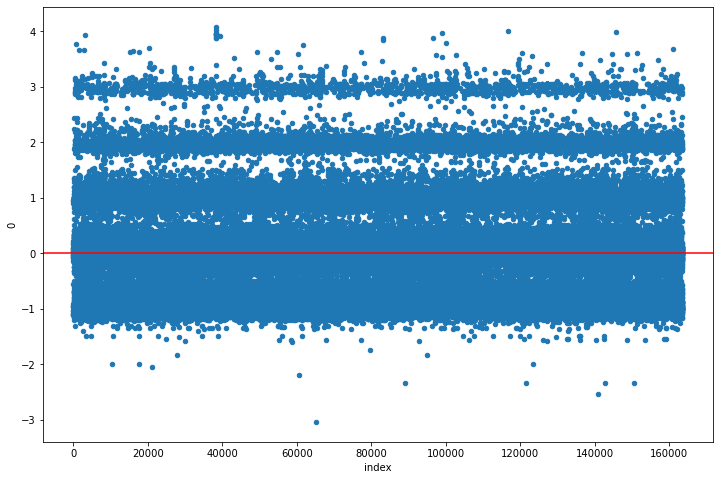

In [65]:
#Comparing estimate to true values
plt.figure()
ax = errors.to_frame().reset_index().plot(kind="scatter", x="index", y=0, figsize=(12, 8))
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [72]:
print("MSE: ", str((errors**2).mean()))
print("MAE: ", str(abs(errors).mean()))

MSE:  0.7321251740615343
MAE:  0.6368035835677596


# Feature: OHE Price

In [76]:
count = set()
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
for i in places_CA:
    count.add(i['price'])
    if i['price'] == '':
        count1 +=1
    if i['price'] == None:
        count2 +=1
    if i['price'] == '$':
        count3 +=1
    if i['price'] == '$$':
        count4 +=1
    if i['price'] == '$$$':
        count5 +=1
count

{'', '$', '$$', '$$$', None}

In [77]:
[count1,count2,count3,count4,count5]

[197, 124356, 2068, 23954, 20696]

In [124]:
#Setup price for each businessID
priceKey = {}
for d in places_CA:
    if d['price'] == None:
        priceKey[d["gPlusPlaceId"]] = ""
    else:
        priceKey[d["gPlusPlaceId"]] = d['price']

In [126]:
prices = []
for d in data_CA5:
    prices.append(d["gPlusPlaceId"])

In [128]:
pohe = np.array(prices).reshape(-1, 1)

In [129]:
enc = OneHotEncoder(drop="first")
priceOHE = enc.fit_transform(pohe)

In [131]:
model = LinearRegression()
model.fit(priceOHE, ratings)

LinearRegression()

In [132]:
estimatesOHE = model.predict(priceOHE)

In [134]:
errors = estimatesOHE - ratings

<Figure size 432x288 with 0 Axes>

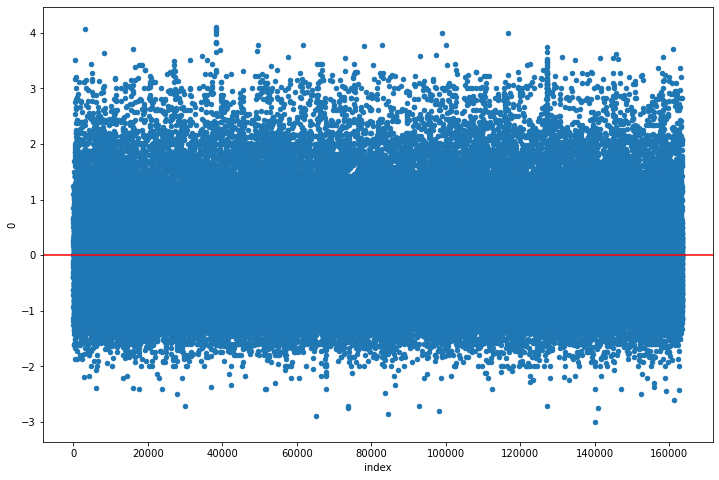

In [136]:
#Comparing estimate to true values
plt.figure()
ax = pd.DataFrame(errors).reset_index().plot(kind="scatter", x="index", y=0, figsize=(12, 8))
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [137]:
print("MSE: ", str((errors**2).mean()))
print("MAE: ", str(abs(errors).mean()))

MSE:  0.6064790483148246
MAE:  0.605784266479489


I feel like this would be a great start:
 - F1 - Cat Avg
 - F2 - OHE Pricing
 - PCA
 - Linear Regression

# Feature: Cosine

# Feature: Category (Some other Way)

**Baseline Model**: Predict the average every time and compute MSE [with and without rounding] (Andrew)<br /> 
**Ablation Experiment**: to determine feature importance<br />
    or Principal Component Analysis<br />
Look at Prof's paper from this dataset

Random Ideas:
1) Naive Bayes?

In [ ]:
#Train-Validation-Validation (65%-20%-15%)
#compare MSE, look into F1?, or other model measurements

Linear Regression Model<br />
Decision Tree Regression/Classification<br />
SVD<br />
K-Nearest Neighbors<br />
Other Models?

Evaluating Overfitting<br />
test on both CA_5 and CA_10